In [352]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from workalendar.europe import Belgium
cal = Belgium()
import itertools
import sys
# Deep learning: 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import model_from_json
import itertools
from sklearn.preprocessing import MinMaxScaler
np.set_printoptions(threshold=sys.maxsize)

In [97]:
holidata = pd.read_pickle('./building1_holidays.pkl')
holidata.index = holidata.index.tz_localize(None)

In [229]:
holidata = pd.read_csv('./Consumption_15min.csv', index_col=0)
holidata.index = pd.to_datetime(holidata.index)
holidata.index = holidata.index.tz_localize(None)
holidata

,Valeur
Datetime,
2014-12-06 00:00:00,7.14
2014-12-06 00:15:00,7.56
2014-12-06 00:30:00,6.72
2014-12-06 00:45:00,6.93
2014-12-06 01:00:00,7.14
...,...
2019-12-31 22:45:00,3.78
2019-12-31 23:00:00,3.99
2019-12-31 23:15:00,3.78


In [256]:
holidata_user = holidata[-672*30+96*2:-672*29+96*2]
holidata_user.to_csv('./building1_input.csv', index=True)
holidata_user

,Valeur
Datetime,
2019-06-07 00:00:00,6.30
2019-06-07 00:15:00,5.88
2019-06-07 00:30:00,6.30
2019-06-07 00:45:00,6.09
2019-06-07 01:00:00,6.30
...,...
2019-06-13 22:45:00,7.14
2019-06-13 23:00:00,6.51
2019-06-13 23:15:00,6.51


In [263]:
holidata_user = holidata[-672*3+96*0:-672*2+96*0]
holidata_user.to_csv('./building1_input2.csv', index=True)
holidata_user.to_csv(deep_learner.import_file_path, index=True)

In [9]:
holidata_user = holidata[-672*38+96*3:-672*37+96*3]
holidata_user.to_csv(deep_learner.import_file_path, index=True)

In [264]:
test_range = holidata[-672*2+96*0:-672*1+96*0]
test_range

,Valeur
Datetime,
2019-12-18 00:00:00,5.25
2019-12-18 00:15:00,5.25
2019-12-18 00:30:00,5.88
2019-12-18 00:45:00,5.25
2019-12-18 01:00:00,4.41
...,...
2019-12-24 22:45:00,4.20
2019-12-24 23:00:00,3.99
2019-12-24 23:15:00,3.78


In [257]:
test_range = holidata[-672*29+96*2:-672*28+96*2]
test_range

,Valeur
Datetime,
2019-06-14 00:00:00,6.09
2019-06-14 00:15:00,6.09
2019-06-14 00:30:00,6.51
2019-06-14 00:45:00,5.88
2019-06-14 01:00:00,5.88
...,...
2019-06-20 22:45:00,4.41
2019-06-20 23:00:00,3.99
2019-06-20 23:15:00,3.78


In [348]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [190]:
class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        #data: pd.DataFrame,
        data_path: str,
        Y_var: str,
        model_save: str,
        model_load: str,
        import_file_path: str,
        export_file_path: str,
        lag: int,
        lag2: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0,
        n_test = 96,
        holi_var = 'working day',
        hour_var_sin = 'hour of day_sin',
        hour_var_cos = 'hour of day_cos',
        day_week_sin = 'day of week_sin',
        day_week_cos = 'day of week_cos',
        month_sin = 'month_sin',
        month_cos = 'month_cos',
        minutes_sin = 'minutes_sin',
        minutes_cos = 'minutes_cos',

    ):
        
        self.data_path = data_path
        self.data = pd.read_csv(data_path, index_col=0)
        #self.data = data
        self.import_file_path = import_file_path
        self.data_user = pd.read_csv(import_file_path, index_col=0)
        self.data_user.index = pd.to_datetime(self.data_user.index)
        self.model_save = model_save
        self.model_load = model_load
        self.export_file_path = export_file_path
        self.Y_var = Y_var 
        self.holi_var = holi_var
        self.hour_var_sin = hour_var_sin
        self.hour_var_cos = hour_var_cos
        self.day_week_sin = day_week_sin
        self.day_week_cos = day_week_cos
        self.month_sin = month_sin
        self.month_cos = month_cos
        self.minutes_sin = minutes_sin
        self.minutes_cos = minutes_cos
        self.lag = lag 
        self.lag2 = lag2
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
        self.n_test = n_test

    def preprocess(self, dataframe):
        dataframe.index = pd.to_datetime(dataframe.index)
        cal = Belgium()
        years = list(range(2014, 2025))
        holidays = []
        for year in years:
            holidays.extend(cal.holidays(year))
        dataframe = dataframe.sort_index()
        dataframe[self.Y_var] = dataframe.iloc[:,0]
        dataframe['working day'] = dataframe.index.map(cal.is_working_day)
        dataframe['hour of day'] = dataframe.index.hour
        dataframe['day of week'] = dataframe.index.dayofweek
        dataframe['date'] = dataframe.index.date
        dataframe['month'] = dataframe.index.month
        dataframe['minutes'] = dataframe.index.minute
        # we encode cynical data into two dimensions using a sine and cosine transformations
        def encode(data, col, max_val):
            data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
            data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
            return data
        dataframe = encode(dataframe, 'hour of day', 23)
        dataframe = encode(dataframe, 'day of week', 6)
        dataframe = encode(dataframe, 'month', 12)
        dataframe = encode(dataframe, 'minutes', 60)
        dataframe = dataframe.drop(['hour of day', 'day of week', 'month', 'minutes'], axis=1)
        dataframe = dataframe.fillna(method='ffill')
        return dataframe
    
    @staticmethod    
    def plot_train_history(model):
        '''
        Convergence plots to have an idea on how the training performs
        '''
        loss = model.history.history['loss']
        val_loss = model.history.history['val_loss']
        plt.figure()
        plt.plot(range(len(loss)), loss, 'b', label='Training loss')
        plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
        #plt.yscale("log")
        plt.xlabel('Epochs')
        plt.ylabel('Losses')
        plt.title('Training and validation losses')
        plt.legend()
        plt.show() 
    
    @staticmethod
    def validation(forecasted, real, parameter):
        ''' 
        compute some important parameters to compare forecasting results
        '''
        value = 0
        value_1 = 0
        value_2 = 0

        if parameter == 'BIAS':
            for i in range(len(forecasted)):
                if real[i] == 0:
                    value += 0
                else: 
                    value += (forecasted[i] - real[i])/(forecasted[i] + real[i])
            final_value = value / len(forecasted) * 100

        elif parameter == 'MAPE':
            for i in range(len(forecasted)):
                if real[i] == 0:
                    value += 0
                else: 
                    value += (abs(real[i] - forecasted[i]))/real[i]
            final_value = value / len(forecasted) * 100

        elif parameter == 'RMSE':
            for i in range(len(forecasted)):
                value += (real[i] - forecasted[i]) ** 2
            final_value = (value / len(forecasted)) ** (1 / 2) 

        elif parameter == 'R':
            for i in range(len(forecasted)):
                value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
                value_1 += (real[i] - np.mean(real)) ** 2
                value_2 += (forecasted[i] - np.mean(forecasted)) ** 2

            if value_1 == 0 or value_2 == 0:
                final_value = 100
            else:
                final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100

        return final_value
        
    @staticmethod
    def create_X_Y(ts: list, holiday: list, hour_cos: list, hour_sin: list, week_cos: list, week_sin: list, month_cos: list, month_sin: list, minute_cos: list, minute_sin: list, lag: int, lag2: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag2):
                Y.append(ts[i + lag2])
                # Substacted 96 for not knowing the day before
                #ab = list(itertools.chain([holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]]))
                #ab = list(itertools.chain([ts[i+lag - lag]], [ts[i+lag - lag2]], [holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]]))
                ab = list(itertools.chain([ts[i+lag2 - lag]], [ts[i+lag2 - lag2]], [holiday[i + lag2]], [hour_cos[i + lag2]], [hour_sin[i + lag2]], [week_cos[i + lag2]], [week_sin[i + lag2]], [minute_cos[i + lag2]], [minute_sin[i + lag2]], [month_cos[i + lag2]], [month_sin[i + lag2]]))
                X.append(ab)
                #X.append(ts[i:(i + lag - 96)] + [holiday[i + lag]] + [hour_cos[i + lag]] + [hour_sin[i + lag]] + )
        
        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None, ahead=False):
        """
        A method to create data for the neural network model
        """
        self.data = self.preprocess(self.data)
        #print(self.data.columns.values)
        
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()
        y_holiday = self.data[self.holi_var].tolist()
        y_hour_cos = self.data[self.hour_var_cos].tolist()
        y_hour_sin = self.data[self.hour_var_sin].tolist()
        y_weekday_cos = self.data[self.day_week_cos].tolist()
        y_weekday_sin = self.data[self.day_week_sin].tolist()
        y_month_cos = self.data[self.month_cos].tolist()
        y_month_sin = self.data[self.month_sin].tolist()
        y_minute_cos = self.data[self.minutes_cos].tolist()
        y_minute_sin = self.data[self.minutes_sin].tolist()
        



        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]
            y_holiday = y_holiday[-use_last_n:]
            y_hour_cos = y_hour_cos[-use_last_n:]
            y_hour_sin = y_hour_sin[-use_last_n:]
            y_weekday_cos = y_weekday_cos[-use_last_n:]
            y_weekday_sin = y_weekday_sin[-use_last_n:]
            y_month_cos = y_month_cos[-use_last_n:]
            y_month_sin = y_month_sin[-use_last_n:]
            y_minute_cos = y_minute_cos[-use_last_n:]
            y_minute_sin =  y_minute_sin[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag, self.lag2)

        # Creating training and test sets 
        X_train = X
        X_val = []
        X_test = []

        Y_train = Y
        Y_val = []
        Y_test = []
        if ahead == False:
            if self.train_test_split > 0:
                index = round((len(X) - self.n_test) * self.train_test_split)
                X_train = X[:(len(X) - index)]
                X_val = X[(len(X) - index):- self.n_test]
                X_test = X[-self.n_test:]     

                Y_train = Y[:(len(X) - index)]
                Y_val = Y[(len(X) - index):- self.n_test]
                Y_test = Y[-self.n_test:]
        #print(X_train.shape)
        #print(Y_train.shape)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
   
    def save_model(self, model):
        model_json = model.to_json()
        with open(self.model_save+'.json', "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights(self.model_save+'.h5')
          
    def load_model(self):
        # load json and create model
        json_file = open(self.model_load+".json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        # load weights into new model
        self.model.load_weights(self.model_load+".h5")
        print("Loaded model from disk")
    
    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_val, X_test, Y_train, Y_val, Y_test = self.create_data_for_NN()
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='msle')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=1,mode='min',patience=7)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            'callbacks': [earlyStop, csv_logger]
            #'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_val, Y_val)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model
        # Plotting train history
        self.plot_train_history(model)
        # Saving the model in json and h5
        self.save_model(self.model)
        
        return model  

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, _, X_test, _, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat
    
    def plot_test(self):
        yhat = self.predict()# Constructing the forecast dataframe
        fc = self.data.tail(len(yhat)).copy()
        fc['forecast'] = yhat
        expected = fc.loc[:,'Valeur']
        predictions = fc.loc[:,'forecast']
        print('RMSE: %f [kWh]' % self.validation(predictions,expected, 'RMSE'))
        print('MAPE: %f %%' % self.validation(predictions,expected, 'MAPE'))
        
        days = np.unique(fc.index.date)
        df = pd.DataFrame(columns = ['Day', 'MAPE', 'NFM', 'day of week', 'workday']) 
        for day in days:
            expected = fc.loc[fc.index.date == day,'Valeur']
            predictions = fc.loc[fc.index.date == day,'forecast']
            if self.validation(predictions,expected, 'MAPE') > 40:
                #print('Day:{} - RMSE:{}'.format(day,self.validation(predictions,expected, 'RMSE')))
                #print('Day:{} - MAPE:{} - NFM:{} - day of week: {} - workday {}'.format(day,self.validation(predictions,expected, 'MAPE'), self.validation(predictions,expected, 'BIAS'), pd.to_datetime(day).day_name(), cal.is_working_day(pd.to_datetime(day))))
                #df.append([day,self.validation(predictions,expected, 'MAPE'), self.validation(predictions,expected, 'BIAS'), pd.to_datetime(day).day_name(), cal.is_working_day(pd.to_datetime(day))])
                df = df.append({'Day': day, 'MAPE': self.validation(predictions,expected, 'MAPE'), 'NFM': self.validation(predictions,expected, 'BIAS'), 'day of week': pd.to_datetime(day).day_name(), 'workday': cal.is_working_day(pd.to_datetime(day))}, ignore_index=True)
        # Ploting the forecasts
        Z(df)
        plt.figure(figsize=(12, 8))
        for dtype in ['Valeur', 'forecast']:  
            plt.plot(fc.index, fc[dtype],label=dtype,alpha=0.7)
        plt.legend()
        plt.grid()

        plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
        plt.yticks(fontsize=12, alpha=.7)
        plt.title("Consumption for test data", fontsize=20)

        plt.show()
        return fc
    
    def predict_n_ahead(self, data_input, n_ahead: int):
        dates = pd.date_range(data_input.index[-1], periods = n_ahead+1, freq='15T')[1:]
        #data_input.index = pd.to_datetime(data_input.index)
        test = data_input.append(pd.DataFrame(index=dates))
        test.index=data_input.index.union(dates)
        test = self.preprocess(test)
        #print(test.columns.values)
        y = test[self.Y_var].tolist()
        #print(len(y))
        y_holiday = test[self.holi_var].tolist()
        #print(len(y_holiday))
        y_hour_cos = test[self.hour_var_cos].tolist()
        y_hour_sin = test[self.hour_var_sin].tolist()
        y_weekday_cos = test[self.day_week_cos].tolist()
        y_weekday_sin = test[self.day_week_sin].tolist()
        y_month_cos = test[self.month_cos].tolist()
        y_month_sin = test[self.month_sin].tolist()
        y_minute_cos = test[self.minutes_cos].tolist()
        y_minute_sin = test[self.minutes_sin].tolist()
        yhat = []
        X, _ = deep_learner.create_X_Y(y, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag, self.lag2)
        #print(X.shape)
        #print(self.model)
        yhat = [y[0] for y in self.model.predict(X)]
        return yhat[-n_ahead:]
    
    def evaluate_n_ahead(self, n_ahead: int):
        data_temp = self.data_user
        #print(len(data_temp))
        #print(data_temp.columns.values)
        yhat = []
        predictions = []
        if hasattr('self', 'model') == False:
            self.load_model()
        for i in tf.range(n_ahead//96+1):
            y_hat = self.predict_n_ahead(data_temp, self.lag)
            #print(len(y_hat))
            data_temp = data_temp.append(pd.DataFrame(y_hat, columns=['Valeur'], index=pd.date_range(data_temp.index[-1], periods = self.lag+1, freq='15T')[1:]))
            #data_temp.resample('15T').interpolate('cubic')
            data_temp.drop(data_temp.head(self.lag).index, inplace=True)
            #print(len(data_temp))
            #print(predictions)
            #print(data_temp.columns.values)
            predictions.extend(y_hat)
        #print(len(predictions))
        predictions = predictions[:n_ahead]
        #print(len(predictions))
        dates = pd.date_range(self.data_user.index[-1], periods = n_ahead+1, freq='15T')[1:]
        #print(len(dates))
        #print(len(predictions))
        test = pd.DataFrame(predictions)
        test.index = dates
        test.index = pd.to_datetime(test.index)
        test.to_csv(self.export_file_path, index=True)
        expected = test_range.head(n_ahead).loc[:,"Valeur"]
        predictions = test.iloc[:,0]
        print('RMSE: %f [kWh]' % self.validation(predictions,expected, 'RMSE'))
        print('MAPE: %f %%' % self.validation(predictions,expected, 'MAPE'))
        plt.figure(figsize=(25, 10))
        plt.grid()
        plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
        plt.yticks(fontsize=12, alpha=.7)
        plt.title("Consumption forecast for given days ahead", fontsize=20)
        plt.plot(test_range.index, test_range.loc[:,"Valeur"], color='orange', label='test', alpha=0.7)
        plt.plot(self.data_user.index, self.data_user.loc[:,"Valeur"], color='b', label='user input data', alpha=0.5)
        plt.plot(test.index, test.iloc[:,0], color='black', linestyle='--', linewidth=3, label='Forecaster model',alpha=0.7)
        plt.legend(prop={'size': 20})
        return test

In [191]:
deep_learner = DeepModelTS(
# USER INPUT SETTINGS
Y_var = 'Valeur',
model_load = "model_B1_complete",
import_file_path = './building1_input.csv',
export_file_path = './predictions.csv',
# TRAINING SETTINGS
data_path = './Consumption_15min.csv',
#data = holidata,
model_save = "model_B1_complete",
lag = 96,
lag2 = 672,
LSTM_layer_depth = 50,
epochs = 200,
batch_size = 128,
train_test_split = 0.15,
n_test = 365*96
)

Epoch 1/200
1196/1196 [==============================] - 4s 3ms/step - loss: 0.2363 - val_loss: 0.0629
Epoch 2/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0608 - val_loss: 0.0592
Epoch 3/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0578 - val_loss: 0.0627
Epoch 4/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0548 - val_loss: 0.0599
Epoch 5/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0526 - val_loss: 0.0573
Epoch 6/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0512 - val_loss: 0.0588
Epoch 7/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0504 - val_loss: 0.0605
Epoch 8/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0500 - val_loss: 0.0600
Epoch 9/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0497 - val_loss: 0.0588
Epoch 10/200
1196/1196 [==============================] - 3s 3ms/step - l

Epoch 80/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0445 - val_loss: 0.0474
Epoch 81/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0445 - val_loss: 0.0474
Epoch 82/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0445 - val_loss: 0.0474
Epoch 83/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0445 - val_loss: 0.0474
Epoch 84/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0445 - val_loss: 0.0474
Epoch 85/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0444 - val_loss: 0.0474
Epoch 86/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0444 - val_loss: 0.0474
Epoch 87/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0444 - val_loss: 0.0474
Epoch 88/200
1196/1196 [==============================] - 3s 3ms/step - loss: 0.0444 - val_loss: 0.0474
Epoch 89/200
1196/1196 [==============================] - 3s 3ms

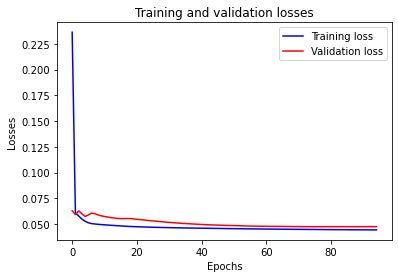

In [167]:
# Fitting the model
model = deep_learner.LSTModel ()

RMSE: 3.062480 [kWh]
MAPE: 22.686398 %


,Day,MAPE,NFM,day of week,workday
0,2019-01-09,47.925880,6.631662,Wednesday,True
1,2019-01-11,69.345185,17.483926,Friday,True
2,2019-01-12,83.286338,26.490002,Saturday,False
3,2019-02-06,61.079862,16.514055,Wednesday,True
4,2019-02-11,109.904771,32.324781,Monday,True
5,2019-03-08,95.841859,27.625074,Friday,True
6,2019-03-11,91.453978,28.698843,Monday,True
7,2019-04-05,57.379178,12.782628,Friday,True
8,2019-04-08,68.295373,22.451338,Monday,True
9,2019-05-10,104.438609,29.605076,Friday,True


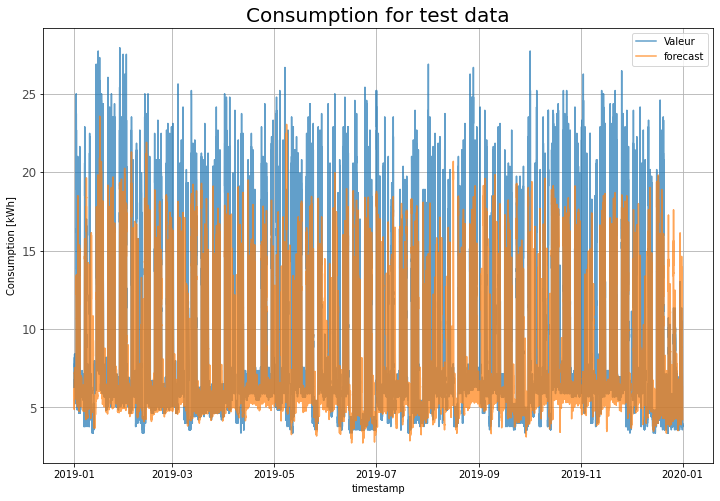

In [193]:
test = deep_learner.plot_test()

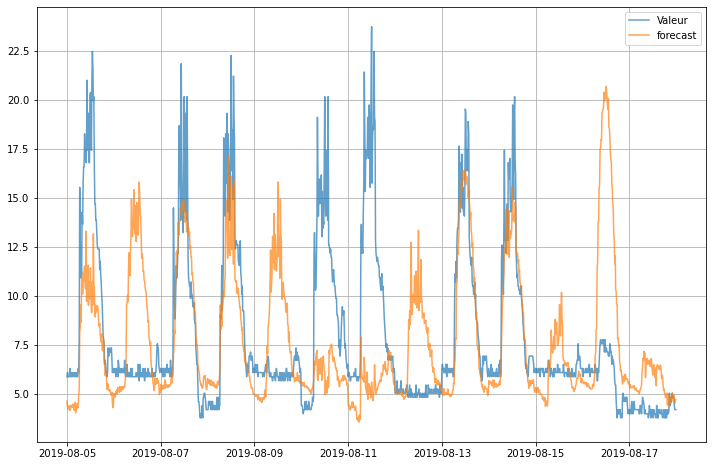

In [341]:
plt.figure(figsize=(12, 8))
fc = test['2019-08-05':'2019-08-17']
for dtype in ['Valeur', 'forecast']:  
    plt.plot(fc.index, fc[dtype],label=dtype,alpha=0.7)
plt.legend()
plt.grid()

[18113.0, 18115.0, 18117.0, 18119.0, 18121.0, 18123.0, 18125.0]
[0, 2, 4, 6, 1, 3, 5]


[Text(18113.0, 0, 'MON'),
 Text(18115.0, 0, 'WED'),
 Text(18117.0, 0, 'FRI'),
 Text(18119.0, 0, 'SUN'),
 Text(18121.0, 0, 'TUE'),
 Text(18123.0, 0, 'THU'),
 Text(18125.0, 0, 'SAT')]

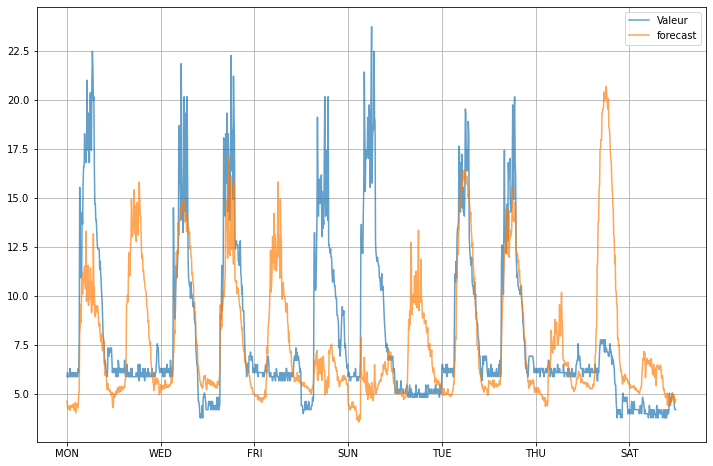

In [347]:
from itertools import groupby

fig, ax = plt.subplots(figsize=(12, 8))
fc = test['2019-08-05':'2019-08-17']
#ax1 = fig.add_subplot(111)
for dtype in ['Valeur', 'forecast']:  
    ax.plot(fc.index, fc[dtype], label=dtype, alpha=0.7)

weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
              4:'FRI', 5:'SAT', 6:'SUN'}
plt.legend()
plt.grid()
xs = sorted(ax.get_xticks())
print(xs)
plt.draw()
dates = []
res = []
wd = ax.get_xticklabels()
labels = [item.get_text() for item in ax.get_xticklabels()]
for label in labels:
    dates.append(dt.datetime.strptime(label, '%Y-%m-%d'))
for date in dates:
    res.append(pd.Timestamp.weekday(date))
#res = dates.apply(pd.Timestamp.weekday())
print(res)
#res = [x for x, _ in groupby(wd)]
ax.set_xticks(xs)
ax.set_xticks([], minor=True)
ax.set_xticklabels([weekday_map[d] for d in res])



In [192]:
deep_learner.test = deep_learner.evaluate_n_ahead(672)

Loaded model from disk


NameError: name 'test_range' is not defined